## Allowing non-specific RNAP binding *within* the promoter

Required packages:

In [1]:
# processing
import math
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from tregs.mpl_pboc import plotting_style

plt.rcParams.update({'font.size': 12})
plotting_style()

fdir = '../data/'
out_fdir = '../plots/fig13/'

### 0. Loading input data

Same as in the notebook `fig3_architecture.ipynb`, we first load the required promoter sequence and energy matrices.

In [2]:
_genome = []
for record in SeqIO.parse(fdir + "mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

df = pd.read_csv(fdir + 'ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

We manually specify the binding site sequences. Note that these sequences all need to be contained within the promoter sequence itself.

In [3]:
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'
rep_site = 'AATTGTGAGCGGATAACAATT'

We read in the known energy matrix for RNA polymerase. This energy matrix is experimentally determined and shown in Figure 2 of Brewster et al., 2012. (https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002). We use the function `fix_wt` from the `tregs` package to normalize the energy matrix such that the wild type base identities correspond to a binding energy of $0\ k_BT$.

In [4]:
rnap_emat_raw = np.loadtxt(fdir + 'energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

Similarly, we read in the experimentally determined energy matrix for the lacI repressor (Barnes et al., 2019) and normalize the energy matrix.

In [5]:
O1_1027_raw = np.load(fdir + 'energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### 1.1 Information footprints when RNAP binds outside of its specific binding sites

To determine the effects of non-specific binding on information footprints, we define a new function for calculating the probability of RNAP being bound, `simrep_ns_pbound`, that includes RNAP binding at each position along the promoter as a unique state. As a first pass, we allow RNAP and repressor to bind at the same position.

In [6]:
def simrep_ns_pbound(promoter_variant, r_seq, n_NS, n_p, n_r,
                     p_emat, r_emat, ep_wt, er_wt):

    w_rnap_tot = 0
    for i in range(160 - p_emat.shape[0]):
        subseq = promoter_variant[i:(i + p_emat.shape[0])].upper()
        w_rnap = tregs.simulate.get_weight(subseq, p_emat, e_wt=ep_wt)
        w_rnap_tot += w_rnap

    w_r = tregs.simulate.get_weight(r_seq, r_emat, e_wt=er_wt)

    return (n_p / n_NS * w_rnap_tot) / (1 + n_p / n_NS * w_rnap_tot + n_r / n_NS * w_r)

We call `tregs.simulate.sim` using `simrep_ns_pbound` as an argument and the wild-type lac promoter sequence and we observe a low level of noise.

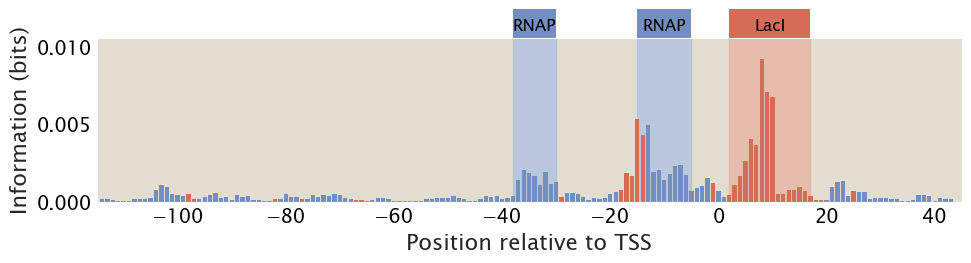

In [7]:
n_NS = len(genome)
n_p = 5000
n_r = 10

ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(promoter, simrep_ns_pbound, [promoter, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(promoter, df, region_params,
                               up_scaling_factor=1.5,
                               outfile='../plots/fig13/R9_fp1.pdf')

Next, we engineer a promoter sequence where it contains a TATA-like motif upstream of the canonical binding sites.

In [8]:
# New subsequence to replace with
motif = "TAGAAT"

# Index from where to start replacing
start_index = 35

new_promoter = promoter[:start_index] + motif + promoter[start_index + len(motif):]
new_promoter

'ACAGGTTTCCCGACTGGAAAGCGGGCAGTGAGCGCTAGAATATTAATGTGAGTTAGCTCACTCATTAGGCACCCCAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGGAATTGTGAGCGGATAACAATTTCACACAGGAAACAGCTATGACCA'

With this new promoter sequence, we again call `tregs.simulate.sim` using `simrep_ns_pbound` as an argument, and we see that there is artificial signal at the position with the TATA-like motif.

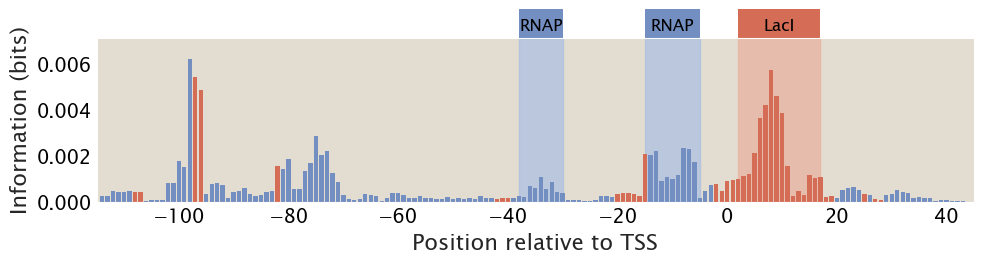

In [9]:
n_NS = len(genome)
n_p = 5000
n_r = 10

ep_wt = -5
er_wt = -15

df = tregs.simulate.sim(new_promoter, simrep_ns_pbound, [new_promoter, rep_site], 
                        *[n_NS, n_p, n_r, rnap_emat, rep_emat, ep_wt, er_wt])

region_params = [(-38, -30, 'P', 'RNAP'), (-15, -5, 'P', 'RNAP'), (2, 17, 'R', 'LacI')]
tregs.footprint.plot_footprint(new_promoter, df, region_params,
                            up_scaling_factor=1.5,
                               outfile='../plots/fig13/R9_fp2.pdf')